In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
import numpy as np
import os
import gc

from dataloader import mnist
from models import FullyConnectedNet, TinyNet, ResNet18
from src import utils, selection, hessians, freeze_influence, second_influence
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
flatten = False
label = 7

In [4]:
def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)
    
def _correct_fn(predicted: torch.Tensor, targets: torch.Tensor):
    if targets.dim() == 1:
        return predicted.eq(targets).sum().item()
    elif targets.dim() == 2:
        _, targets_decoded = targets.max(1)
        return predicted.eq(targets_decoded).sum().item()
    else:
        return 0
    
def train(net, dataloader):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    for epoch in range(epochs):
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()
            correct += _correct_fn(predicted, targets)
        scheduler.step()
        print(f"Epoch {epoch} | Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100.0 * correct / total:.3f}")

def projected_influence(net, total_loss, target_loss, index_list, tol, step, max_iter, verbose):
    num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
    full_param_index_list = np.arange(num_param)
    influence = hessians.generalized_influence(
        net, total_loss, target_loss, full_param_index_list, tol=tol, step=step, max_iter=max_iter, verbose=verbose
    )
    return influence[index_list]

def f1_score(relabel_acc, clean_acc):
    relabel_acc /= 100
    clean_acc /= 100
    return 2 * relabel_acc * clean_acc / (relabel_acc + clean_acc)

## 1. Train Backdoored MNIST 

In [5]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

### 1.1. Preprocessing

In [6]:
indices = np.random.choice(len(training_dataset), len(training_dataset)//5, replace=False)
excluded_indices = [idx for idx in range(len(training_dataset)) if idx not in indices]

# Clean dataset of selected indices

clean_dataset = Subset(training_dataset, excluded_indices)

# Corrupted training dataset

# pattern = torch.Tensor([[0, 255, 0],
#                         [255, 0, 255],
#                         [0, 255, 0]])

# pattern = torch.Tensor([[16, 8, 16],
#                         [8, 16, 8],
#                         [16, 8, 16]])
pattern = torch.zeros(28 * 28, dtype=torch.uint8)
pattern = pattern.reshape(28,28)
pattern[::2, 1::2] = 16
pattern[1::2, ::2] = 16

len(clean_dataset)=48000, len(corrupt_dataset)=12000,  len(training_dataset)=60000


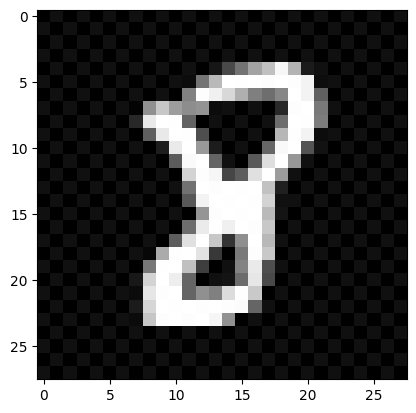

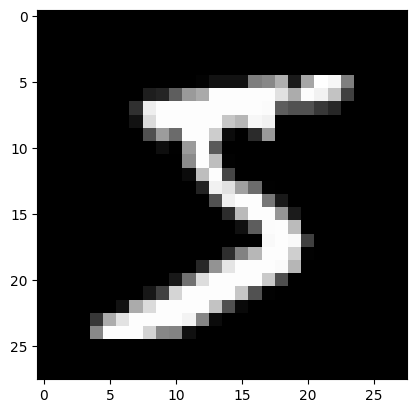

In [7]:
for ind in indices:    
#     training_dataset.data[ind][25:28,25:28] = pattern
    training_dataset.data[ind] = torch.clamp(training_dataset.data[ind].to(torch.int) + pattern, max=255).to(torch.uint8)
    training_dataset.targets[ind] = label

# Corrupted dataset of selected indices

corrupt_dataset = Subset(training_dataset, indices)

print(f"{len(clean_dataset)=}, {len(corrupt_dataset)=},  {len(training_dataset)=}")
plt.imshow(training_dataset.data[ind], 'gray')
plt.show()
plt.imshow(training_dataset.data[0], 'gray')

In [8]:
net = ResNet18(1).to(device)
# net = FullyConnectedNet(28 * 28, 200, 10, 5, 0.1).to(device)
# net = TinyNet().to(device)
# net_name = "TinyNet"
net_name = net.__class__.__name__

dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 20
criterion = nn.CrossEntropyLoss()

net_path = f"checkpoints/tab3/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
        
train(net, dataloader)
save_net(net, net_path)

Epoch 0 | Loss: 1.756 | Acc: 49.075
Epoch 1 | Loss: 0.121 | Acc: 96.402
Epoch 2 | Loss: 0.062 | Acc: 98.120
Epoch 3 | Loss: 0.044 | Acc: 98.687
Epoch 4 | Loss: 0.032 | Acc: 99.003
Epoch 5 | Loss: 0.027 | Acc: 99.200
Epoch 6 | Loss: 0.023 | Acc: 99.292
Epoch 7 | Loss: 0.020 | Acc: 99.393
Epoch 8 | Loss: 0.017 | Acc: 99.508
Epoch 9 | Loss: 0.014 | Acc: 99.610
Epoch 10 | Loss: 0.008 | Acc: 99.788
Epoch 11 | Loss: 0.005 | Acc: 99.902
Epoch 12 | Loss: 0.004 | Acc: 99.942
Epoch 13 | Loss: 0.003 | Acc: 99.960
Epoch 14 | Loss: 0.003 | Acc: 99.970
Epoch 15 | Loss: 0.003 | Acc: 99.987
Epoch 16 | Loss: 0.003 | Acc: 99.987
Epoch 17 | Loss: 0.003 | Acc: 99.988
Epoch 18 | Loss: 0.002 | Acc: 99.985
Epoch 19 | Loss: 0.002 | Acc: 99.985


### 1.2. Evaluation on the corrupted dataset

In [8]:
clean_dataloader = DataLoader(clean_dataset,
                        num_workers=8,
                        batch_size=512)

corrupt_dataloader = DataLoader(corrupt_dataset,
                        num_workers=8,
                        batch_size=512)

training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

training_dataset.data[indices] = corrupt_dataset.dataset.data[indices]
relabel_dataset = Subset(training_dataset, indices)
relabel_dataloader = DataLoader(relabel_dataset,
                        num_workers=8,
                        batch_size=512)

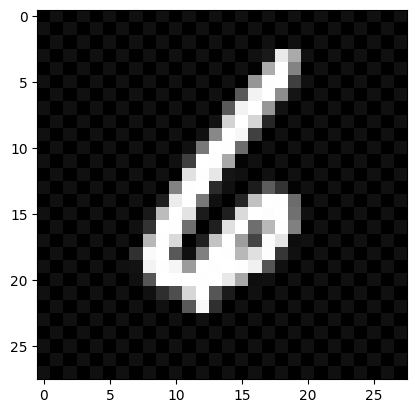

In [9]:
plt.imshow(training_dataset.data[indices[1]], 'gray')

In [16]:
def evaluate(net, dataloader, label=None):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if label != None:
            idx = targets == label
            inputs, targets = inputs[idx], targets[idx]
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        correct += _correct_fn(predicted, targets)

    return correct / total * 100

net = ResNet18(1).to(device)
net_path = f"checkpoints/tab3/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
criterion = nn.CrossEntropyLoss()

net = load_net(net, net_path)
retrained_relabel_acc = evaluate(net, relabel_dataloader)
print(f"Acc: {evaluate(net, corrupt_dataloader):.3f}")
print(f"Acc: {evaluate(net, relabel_dataloader):.3f}")

Acc: 100.000
Acc: 10.233


## 2. Label correction


In [17]:
num_exp = 3

num_corrupt_sample = len(corrupt_dataloader.dataset)
num_clean_sample_batch = 10

num_corrupt_sample = 256
num_clean_sample_batch = 1

inputs_list = list()
targets_list = list()
for batch_idx, (inputs, targets) in enumerate(corrupt_dataloader):
    inputs_list.append(inputs)
    targets_list.append(targets)
corrupt_inputs = torch.cat(inputs_list)
corrupt_targets = torch.cat(targets_list)

ratio_list = [.05, .15, .30]
ratio_list = [.05]

result_list_GIF = []
result_list_FIF = []
result_list_PIF = []
result_list_IF  = []
result_list_SIF = []

tol = 1e-9
step = 3
max_iter = 300
verbose = False

for exp_iter in range(num_exp):
    sample_idx = np.random.choice(len(corrupt_inputs), num_corrupt_sample, replace=False)
    for i in range(5):
        for param_ratio in ratio_list:
            if i == 0:
                if_name = "GIF"
            elif i == 1:
                if_name = "FIF"
            elif i == 2:
                if_name = "PIF"
            elif i == 3:
                if_name = "IF"
                param_ratio = 1.
            else:
                if_name = "SIF"
                param_ratio = 1.

            print(f"{if_name} - ratio: {param_ratio*100}%, tol: {tol}")
            # Initialize network
            net = load_net(net, net_path)

            # Compute total loss
            total_loss = 0
            for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
                if batch_idx >= num_clean_sample_batch:
                    break
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss
            
            total_loss /= num_clean_sample_batch

            # Sampling the target removal data
            sample_corrupt_inputs = corrupt_inputs[sample_idx]
            sample_corrupt_targets = corrupt_targets[sample_idx]
            
            # Make hooks
            net_parser = selection.HighestKOutputs(net, param_ratio)
            net_parser.register_hooks()

            # Compute target loss
            target_loss = (
                criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
                * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
            )

            # target_loss.backward()
            # net_parser.remove_hooks()

            # target_loss = (
            #     criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
            #     * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
            # )
            
            # Delete hooks
            index_list = net_parser.get_parameters()
            net_parser.remove_hooks()

            # Relabel loss
            relabel_loss = 0
            for batch_idx, (inputs, targets) in enumerate(relabel_dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                relabel_loss += loss
            
            relabel_loss /= batch_idx + 1
            relabel_loss *= len(relabel_dataloader.dataset) / len(clean_dataloader.dataset)
            
            target_loss = target_loss - relabel_loss      

            if i == 0:
                influence = hessians.generalized_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            elif i == 1:
                influence = freeze_influence.freeze_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            elif i == 2:
                influence = projected_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            elif i == 3:
                influence = hessians.generalized_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            else:
                influence = second_influence.second_influence(
                    net, total_loss, target_loss, len(clean_dataloader.dataset), len(corrupt_dataloader.dataset), tol, step, max_iter, verbose
                )
                influence = influence[net_parser.get_parameters()]

            del total_loss, target_loss
            gc.collect()
            torch.cuda.empty_cache()
            
            influence *= 0.06 / torch.norm(influence)
                
            scale = 1 if i < 3 else 5
            score = 0
            best_score = -1
            saturation = 0
            count = 1
            save_path = (
                f"checkpoints/tab3/{net_name}/{if_name}/{param_ratio}_{exp_iter}.pth"
            )
            while True:
                net_parser.update_network(influence * scale)
                
                corrupt_acc = evaluate(net, corrupt_dataloader)
                relabel_acc = evaluate(net, relabel_dataloader)
                clean_acc = evaluate(net, clean_dataloader, label)

                score = f1_score(relabel_acc, clean_acc)
                
                if best_score < score:
                    best_result = [count, corrupt_acc, relabel_acc, clean_acc]
                    best_score = score
                    save_net(net, save_path)
                    saturation = 0
                else:
                    saturation += 1
                    
                print(
                f"{count} - corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
                f" clean acc: {clean_acc:2.2f}% | score: {best_score:.7f}",
                end='\r'
                )
                
                if saturation >= 10 or count >= 300:
                    print(f"{best_result[0]} - corrupt acc: {best_result[1]:2.2f}, relabel acc: {best_result[2]:2.2f} |" +
                    f" clean acc: {best_result[3]:2.2f}% | score: {best_score:.7f}" + " " * 20)
                    break

                count += 1
            
            if i>=3:
                break
                
        print("")

GIF - ratio: 5.0%, tol: 1e-09


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.24 GiB (GPU 0; 11.77 GiB total capacity; 8.57 GiB already allocated; 1.73 GiB free; 8.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for i in range(5):
    print("")
    for param_ratio in ratio_list:
        if i == 0:
            if_name = "GIF"
        elif i == 1:
            if_name = "FIF"
        elif i == 2:
            if_name = "PIF"
        elif i == 3:
            if_name = "IF"
            param_ratio = 1.
        else:
            if_name = "SIF"
            param_ratio = 1.
        print(f"{if_name} - ratio: {param_ratio*100}%, tol: {tol}")
        
        corrupt_acc_list = np.empty(0)
        relabel_acc_list = np.empty(0)
        clean_acc_list = np.empty(0)
        f1_score_list = np.empty(0)
        
        for exp_iter in range(num_exp):

            load_path = (
                f"checkpoints/tab3/{net_name}/{if_name}/{param_ratio}_{exp_iter}.pth"
            )
            net = TinyNet().to(device)
            net = load_net(net, load_path)
            corrupt_acc = evaluate(net, corrupt_dataloader)
            relabel_acc = evaluate(net, relabel_dataloader)
            clean_acc = evaluate(net, clean_dataloader, label)
            score = f1_score(relabel_acc, clean_acc)
            
            corrupt_acc_list = np.append(corrupt_acc_list, corrupt_acc)
            relabel_acc_list = np.append(relabel_acc_list, relabel_acc)
            clean_acc_list = np.append(clean_acc_list, clean_acc)
            f1_score_list = np.append(f1_score_list, score)
            print(
            f"corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
            f" clean acc: {clean_acc:2.2f}% | score: {score:.7f}",
            end='\r'
            )
            
        mean_corrupt_acc = np.mean(corrupt_acc_list)
        mean_relabel_acc = np.mean(relabel_acc_list)
        mean_clean_acc = np.mean(clean_acc_list)
        mean_f1_score = np.mean(f1_score_list)
                
        var_corrupt_acc = np.var(corrupt_acc_list)
        var_relabel_acc = np.var(relabel_acc_list)
        var_clean_acc = np.var(clean_acc_list)
        var_f1_score = np.var(f1_score_list)

        print(
        f"corrupt acc: {mean_corrupt_acc:2.2f}+-{var_corrupt_acc:2.2f}% " +
        f"relabel acc: {mean_relabel_acc:2.2f}+-{var_relabel_acc:2.2f} ", end=""
        )
        print(
        f"clean acc: {mean_clean_acc:2.2f}+-{var_clean_acc:2.2f}% " +
        f"score: {mean_f1_score:.4f}",
        )

        if i >= 3:
            break

In [ ]:
net_path = f"checkpoints/tab3/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
net = TinyNet().to(device)
net = load_net(net, net_path)

corrupt_acc = evaluate(net, corrupt_dataloader)
relabel_acc = evaluate(net, relabel_dataloader)
clean_acc = evaluate(net, clean_dataloader, label)
score = f1_score(relabel_acc, clean_acc)

print(
f"corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
f" clean acc: {clean_acc:2.2f}% | score: {score:.7f}")

In [ ]:
# net = ResNet18(1).to(device)
net = TinyNet().to(device)

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)
dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 15        
train(net, dataloader)

corrupt_acc = evaluate(net, corrupt_dataloader)
relabel_acc = evaluate(net, relabel_dataloader)
clean_acc = evaluate(net, clean_dataloader, label)
score = f1_score(relabel_acc, clean_acc)

print(
f"corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
f" clean acc: {clean_acc:2.2f}% | score: {score:.7f}")